In [2]:
#importandoa as biblioetcas usadas para a preparação dos dados e predição
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [270]:
#importando as biblioteca da api
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder
#buscando todos os jogos
result = leaguegamefinder.LeagueGameFinder()
todosJogos = result.get_data_frames()[0]

In [271]:
#tranformando os dados da api em um dataframe
df = pd.DataFrame(todosJogos)

In [272]:
#retirando os dados que nao sera usado na api
df.drop(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID','GAME_DATE', 'MATCHUP'], axis=1, inplace=True)
df.head()

,WL,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,L,241,106,41,85,0.482,6,29,0.207,18,...,0.750,10,37,47,21,11,8,16,21,-6.0
1,L,242,95,33,91,0.363,16,49,0.327,8,...,0.615,18,41,59,22,6,11,19,22,-4.0
2,L,241,116,41,99,0.414,12,48,0.250,22,...,0.815,9,31,40,21,13,4,12,21,-7.0
3,W,241,104,33,74,0.446,11,34,0.324,27,...,0.931,3,41,44,21,7,4,14,16,2.0
4,L,242,91,34,91,0.374,12,37,0.324,11,...,0.647,10,30,40,21,8,3,16,16,-32.0


In [273]:
df['WL'] = pd.get_dummies(df['WL'])

In [274]:
#Transformando os dados categóricos de  WINorLOSS para numeros
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['WL'])
df['WL'] = df['WL'].fillna(df['WL'].mean())
df['WL'] = le.transform(df['WL'])

In [275]:
#normalizando os dados
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df.drop('WL',axis=1))
df_normalizado = scaler.transform(df.drop('WL',axis=1))
from sklearn.preprocessing import StandardScaler
df_param = pd.DataFrame(df_normalizado, columns=df.columns[1:])
df_param = df_param.fillna(df_param.mean())

In [276]:
#importando para separar dos dados de teste e de treino
from sklearn.model_selection import train_test_split

In [277]:
#separando os dados de treino de teste sendo 40% para teste e 60% para treino e escolhedo o um random 
x_treino, x_teste, y_treino, y_teste = train_test_split(df_param,df['WL'],test_size=0.4,random_state=101)
aux = y_teste.reset_index()
aux.drop('index',axis=1,inplace=True)

In [278]:
#prenchendo os dados faltantes com a media dos valores
x_treino = x_treino.fillna(x_treino.mean())
x_teste = x_teste.fillna(x_teste.mean())
y_treino = y_treino.fillna(y_treino.mean())
y_teste = y_teste.fillna(y_teste.mean())

In [279]:
#importando o algoritmo de vou uzar para a prediçao e inicializando
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)

In [280]:
#encontrando e fazendo os modelos de treino e fazendo a normalização dos dados
y_treino = le.fit_transform(y_treino)
knn.fit(x_treino,y_treino)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [281]:
#fazendo a prediçao
predicao = knn.predict(x_teste)

Text(0, 0.5, 'Y valor predito')

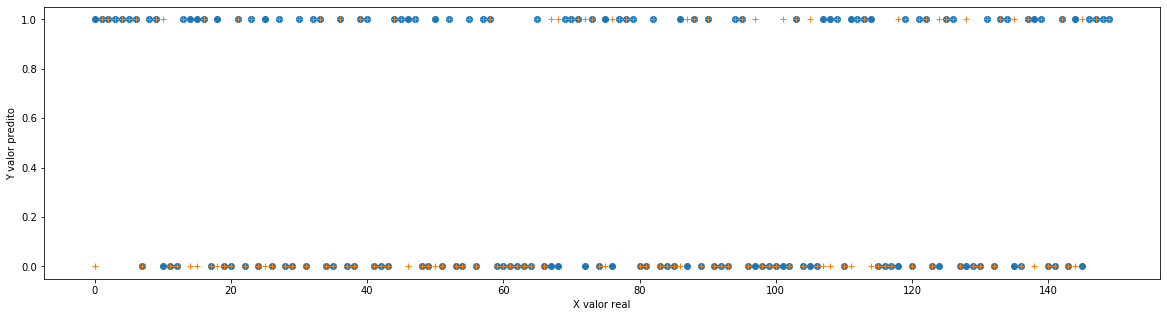

In [282]:
plt.figure(figsize=(20,5))
plt.plot(aux[:150], 'o')
plt.plot(predicao[:150], '+')
plt.xlabel('X valor real')
plt.ylabel('Y valor predito')

In [1]:
from sklearn import metrics
#MAE é o mais fácil de entender, porque é o erro médio.
#MSE é mais popular que o MAE, porque a MSE "puniria" erros maiores, o que tende a ser útil no mundo real.
#RMSE é ainda mais popular do que MSE, porque o RMSE é interpretável nas unidades "y".
print('MAE:  %.5f' % metrics.mean_absolute_error(y_teste, predicao))
print('MSE:  %.5f' % metrics.mean_squared_error(y_teste, predicao))
print('RMSE: %.5f'% np.sqrt(metrics.mean_squared_error(y_teste, predicao)))

NameError: name 'y_teste' is not defined

In [284]:
print('Variance score: %.2f' % knn.score(x_teste,aux))

Variance score: 0.86


In [287]:
from sklearn.model_selection import cross_val_score
aux1 = le.fit_transform(df['WL'])
scores = cross_val_score(knn, df_param,aux1, cv=10)

In [288]:
print('Variance Cros-Validation rscore: %.2f' % max(scores))

Variance Cros-Validation rscore: 0.89


In [289]:
from sklearn.metrics import classification_report
print(classification_report(y_teste,predicao))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      6063
           1       0.85      0.86      0.86      5937

    accuracy                           0.86     12000
   macro avg       0.86      0.86      0.86     12000
weighted avg       0.86      0.86      0.86     12000



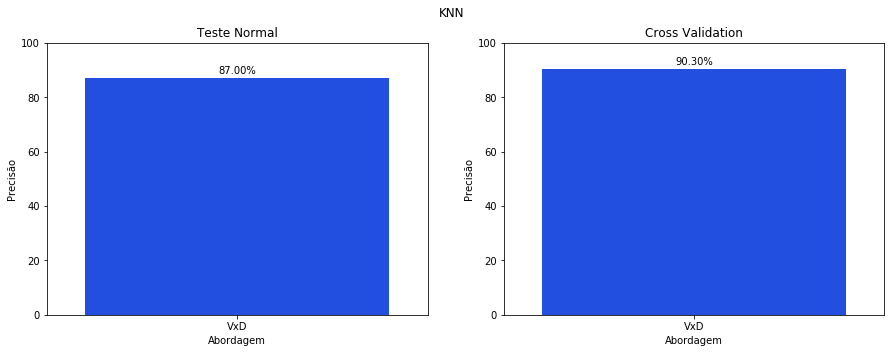

In [3]:
plt.figure(figsize=(15,5))
plt.suptitle('KNN')

plt.subplot(1, 2, 1)
plt.title("Teste Normal")

graph = sns.barplot(x=['VxD'], y=[87],palette='bright')
for p in graph.patches:
    graph.annotate(format(p.get_height(), '.2f') + "%", (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 8), textcoords = 'offset points')
plt.xlabel("Abordagem")
plt.ylabel("Precisão")
plt.ylim([0, 100])

plt.subplot(1, 2, 2)
plt.title("Cross Validation")
graph2 = sns.barplot(x=['VxD'], y=[90.3],palette='bright')
for p in graph2.patches:
    graph2.annotate(format(p.get_height(), '.2f') + "%", (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 8), textcoords = 'offset points')
plt.xlabel("Abordagem")
plt.ylabel("Precisão")
plt.ylim([0, 100])
plt.savefig('img/knnAPI.png')